# A very brief introduction with CLAP model architecture and music data

**Author**: [Mahbub Ul Alam](https://www.linkedin.com/in/anondo)

## Introduction and some inferencing

"[**CLAP (Contrastive Language-Audio Pretraining)**](https://github.com/microsoft/CLAP) is a model that learns acoustic concepts from natural language supervision and enables **Zero-Shot inference**. The model has been extensively evaluated in 26 audio downstream tasks achieving SoTA in several of them including classification, retrieval, and captioning."

CLAP connects language and audio by using **two encoders** and a **contrastive learning** objective, bringing audio and text descriptions into a **joint multimodal** space. More can be read from the paper entitled [**CLAP: Learning Audio Concepts from Natural Language Supervision**](https://ieeexplore.ieee.org/abstract/document/10095889)

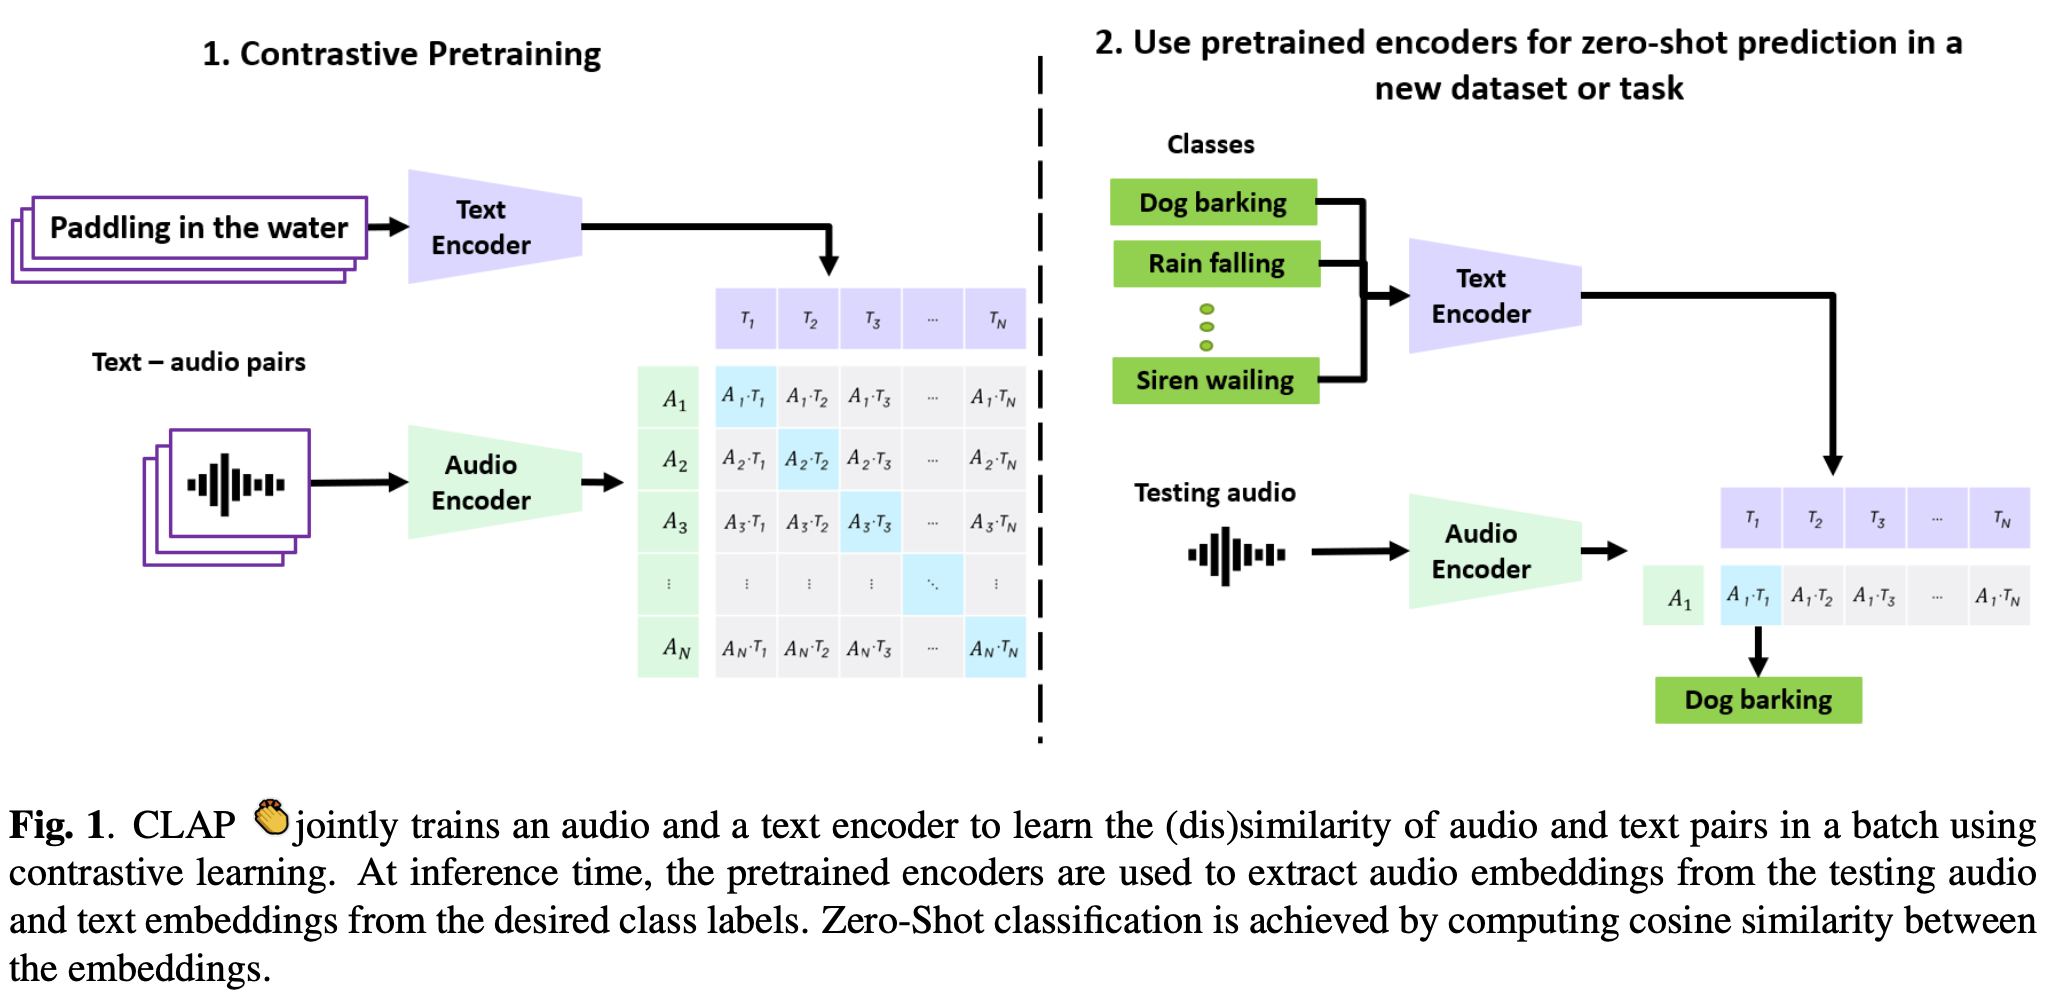

**CLAP pretrained-models can be obtained using this link:** https://zenodo.org/record/8378278

### Declaration and Initialization

This notebook should be run from **inside the 'src/' directory of the [CLAP](https://github.com/microsoft/CLAP)** github project repository. 

In [282]:
import pandas as pd
import numpy as np
from CLAPWrapper import CLAPWrapper
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
import hdbscan
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import copy
import time

print("Numpy Version: ",np.__version__)

Numpy Version:  1.23.5


In [94]:
# all variable initiations should be here

data_dir = r"data/"
audio_file_dir=r"musimotion_youtube_subtestset/"
weights_dir = r"CLAP_models/"

annotation_file_name=r"musimotion_testset_annotations_cut.csv"
weights_file= r"CLAP_weights_2023.pth"
caption_weights_file=r"clapcap_weights_2023.pth"

threshold_value=70

random_instance_number = 10

### Tabular data processing

The music dataset can be obtained using the following links,

[**CSV file with annotations for 67 genres on 670 tracks**](https://drive.google.com/file/d/1Qeb1li9IY8skmuMFA9FM8RyM3KGrte8g/view?usp=sharing)

[**The audio files for these tracks as mp3 files**](https://drive.google.com/file/d/1AOZ8IwNo8nSbIRFr8rqzjnbQQ2bnxKNN/view?usp=sharing)

In [17]:
# as the dataset is multi-labeled, so here we can tune the threshold label score 
#(for example 90 or more) to create different datasets based on our needs
# threshold_value = 'max' means we are creating a single-label dataset

def filter_multi_label_scores(df, threshold_value):
    
    all_music_file_names=np.array(df[df.columns[0]])
    
    all_class_names=np.array(df.columns)
    
    all_class_names = np.delete(all_class_names, 0)
    
    class_to_idx=dict()    
    for i, category in enumerate(all_class_names):
        class_to_idx[category] = i
    
    instance_wise_class_scores=np.array(df.drop(columns=[df.columns[0]]))
    
   
    instance_wise_selected_class_scores=[]
    instance_wise_selected_class_names=[]
    instance_wise_selected_audio_file_names=[]
    instance_wise_selected_class_indices=[]

    for instance_index in range(len(all_music_file_names)):
    
        audio_file_name=all_music_file_names[instance_index]

        instance_class_scores = instance_wise_class_scores[instance_index]
    
        if threshold_value!='max':
        
            more_than_threshold_valued_indices = np.asarray(instance_class_scores>=threshold_value).nonzero()
        
        else: 
        
            more_than_threshold_valued_indices = np.asarray(instance_class_scores==max(instance_class_scores)).nonzero()
    
        selected_class_scores = instance_class_scores[more_than_threshold_valued_indices]
    
        selected_class_names = all_class_names[more_than_threshold_valued_indices]
    
        if threshold_value!='max' and len(selected_class_scores)>0:
            
            instance_wise_selected_class_scores.append(selected_class_scores.tolist())
            instance_wise_selected_class_names.append(selected_class_names.tolist())
            instance_wise_selected_audio_file_names.append(audio_file_name)
            
        elif threshold_value=='max' and max(instance_class_scores)>0:
            
            class_idx = class_to_idx[selected_class_names[0]]
            
            instance_wise_selected_class_scores.append(selected_class_scores[0])
            instance_wise_selected_class_names.append(selected_class_names[0])
            instance_wise_selected_audio_file_names.append(audio_file_name)
            instance_wise_selected_class_indices.append(class_idx)
            
            
    info_dict = dict()
    
    info_dict['instance_wise_selected_class_scores']=instance_wise_selected_class_scores
    info_dict['instance_wise_selected_class_names']=instance_wise_selected_class_names
    info_dict['instance_wise_selected_audio_file_names']=instance_wise_selected_audio_file_names
    
    if threshold_value=='max':
        info_dict['instance_wise_selected_class_indices']=instance_wise_selected_class_indices
         
    
    return info_dict

### Zero-shot inference with CLAP model architecture

Now we will try to use the zero-shot inference with the music dataset.

In [9]:
multi_label_info_dict=filter_multi_label_scores(pd.read_csv(data_dir+annotation_file_name, sep='\t'), threshold_value)

In [11]:
# selecting random instances for zeroshot inference
random_instance_indices = np.random.choice(len(multi_label_info_dict['instance_wise_selected_audio_file_names']), random_instance_number, replace=False)

zero_shot_inference_selected_audio_file_names=[]
zero_shot_inference_selected_multi_label_class_names=[]
zero_shot_inference_selected_class_scores=[]

for random_instance_index in random_instance_indices:
    zero_shot_inference_selected_class_scores.append(multi_label_info_dict['instance_wise_selected_class_scores'][random_instance_index])
    zero_shot_inference_selected_audio_file_names.append(multi_label_info_dict['instance_wise_selected_audio_file_names'][random_instance_index])
    zero_shot_inference_selected_multi_label_class_names.append(multi_label_info_dict['instance_wise_selected_class_names'][random_instance_index])

In [12]:
# Define classes for zero-shot
# Should be in lower case and can be more than one word

classes=list(set([x.lower() for x in [item for row in zero_shot_inference_selected_multi_label_class_names for item in row]]))

# Add prompt
prompt = 'the genre of this song is '
class_prompts = [prompt + x for x in classes]

audio_files = [data_dir+audio_file_dir+file_name for file_name in zero_shot_inference_selected_audio_file_names]

# Load and initialize CLAP

weights_path=data_dir+weights_dir+weights_file

# Setting use_cuda = True will load the model on a GPU using CUDA
clap_model = CLAPWrapper(weights_path, version = '2023', use_cuda=False)

# compute text embeddings from natural text
text_embeddings = clap_model.get_text_embeddings(class_prompts)

# compute the audio embeddings from an audio file
audio_embeddings = clap_model.get_audio_embeddings(audio_files, resample=True)


# compute the similarity between audio_embeddings and text_embeddings
similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)

similarity_softmax = F.softmax(similarity, dim=1)


In [13]:
# Print the results
    
for i in range(len(audio_files)):

    values, indices = similarity_softmax[i].topk(5)    

    #print(str(i+1)+' Ground Truth (Single Label): '+ground_truth_single[i])
    print(i+1)
    print('Class labels:')
    print(zero_shot_inference_selected_multi_label_class_names[i])
    print()
    print('Class label annotation scores:')
    print(zero_shot_inference_selected_class_scores[i])
    print()
    print("Top predictions:\n")
    for value, index in zip(values, indices):
        print(f"{classes[index]:>16s}: {100 * value.item():.2f}%")
    print()

1
Class labels:
['R&B - Nu Soul', 'Soul']

Class label annotation scores:
[100.0, 88.0]

Top predictions:

   r&b - nu soul: 56.12%
            soul: 15.73%
             pop: 15.06%
       dancehall: 5.89%
       dance pop: 5.78%

2
Class labels:
['Industrial', 'Noise Music']

Class label annotation scores:
[100.0, 95.0]

Top predictions:

      industrial: 64.32%
     noise music: 24.23%
electro body music: 3.29%
             pop: 2.72%
        pop rock: 1.77%

3
Class labels:
['Rock N Roll']

Class label annotation scores:
[100.0]

Top predictions:

     rock n roll: 42.22%
        pop rock: 12.75%
       dance pop: 8.48%
       dancehall: 8.23%
             pop: 8.17%

4
Class labels:
['Dancehall']

Class label annotation scores:
[100.0]

Top predictions:

       dancehall: 58.40%
samba - bossa nova - mpb: 25.19%
   r&b - nu soul: 13.72%
       dance pop: 1.64%
            soul: 0.50%

5
Class labels:
['Indie Rock', 'Pop Rock']

Class label annotation scores:
[88.0, 100.0]

Top pred

We can observe that for most of the cases the result is close to the ground truths.

### Zero-shot captioning with CLAP model architecture

In [14]:
caption_weights_path=data_dir+weights_dir+caption_weights_file

clap_caption_model = CLAPWrapper(caption_weights_path, version = 'clapcap', use_cuda=False)

# Generate captions
captions = clap_caption_model.generate_caption(audio_files, resample=True, beam_size=5, entry_length=67, temperature=0.01)

In [15]:
# Print the result
for i in range(len(audio_files)):
    print(i+1)
    print('Class labels:')
    print(zero_shot_inference_selected_multi_label_class_names[i])
    print()
    print(f"Audio file: {zero_shot_inference_selected_audio_file_names[i]} \n")
    print(f"Generated caption: {captions[i]} ")
    print("===============================\n")

1
Class labels:
['R&B - Nu Soul', 'Soul']

Audio file: y7mwZULsVcQ.mp3 

Generated caption: A radio is playing music and a song is being played.  

2
Class labels:
['Industrial', 'Noise Music']

Audio file: OZWmYEUoweg.mp3 

Generated caption: A vehicle drives by and a car drives by.  

3
Class labels:
['Rock N Roll']

Audio file: ZFo8-JqzSCM.mp3 

Generated caption: A man is singing and a dog is barking.  

4
Class labels:
['Dancehall']

Audio file: NKJIIHgy1E0.mp3 

Generated caption: A person is eating a food and then a radio is played.  

5
Class labels:
['Indie Rock', 'Pop Rock']

Audio file: AVYYpNaSs2Y.mp3 

Generated caption: A music video is playing and a song is playing.  

6
Class labels:
['Electro Body Music', 'Electro Pop']

Audio file: 2krPtELFkks.mp3 

Generated caption: A loud organ is playing a beat.  

7
Class labels:
['Dance Pop', 'Pop']

Audio file: C-u5WLJ9Yk4.mp3 

Generated caption: A radio station is playing music and a radio station is playing music.  

8
Class

The captions are quite interesting and not very close to the genre. Pretraining with detail genre information might help in this regard.

## Extracting audio encodings using CLAP model architecture

Now we will extract the audio encodings using the CLAP model. We are saving the single class information for later visualization and clustering use.

In [18]:
single_label_info_dict=filter_multi_label_scores(pd.read_csv(data_dir+annotation_file_name, sep='\t'), 'max')

new_df = pd.DataFrame(list(zip(single_label_info_dict['instance_wise_selected_audio_file_names'], single_label_info_dict['instance_wise_selected_class_names'])),
               columns =['file_name', 'class_name'])

new_df.to_csv(data_dir+'musimotion_testset_single_class_v2.csv', index=False)  

In [61]:
#saving it for visualizing later
np.savetxt(data_dir+"embedding_class_names.csv", np.array(single_label_info_dict['instance_wise_selected_class_names']), delimiter="\t", fmt='%s')

audio_embeddings_list=[]

for i in tqdm(range(len(single_label_info_dict['instance_wise_selected_audio_file_names']))):
    
    audio_file_path=data_dir+audio_file_dir+single_label_info_dict['instance_wise_selected_audio_file_names'][i]
    
    audio_embeddings_list.append(clap_model.get_audio_embeddings([audio_file_path], resample=True))
    
audio_embeddings_tensors=torch.stack(audio_embeddings_list)


audio_embeddings_tensors= audio_embeddings_tensors.reshape(audio_embeddings_tensors.shape[0], audio_embeddings_tensors.shape[2])

#print(audio_embeddings_tensors.shape)

#saving it for visualizing and clustering later
np.savetxt(data_dir+"audio_encodings.csv", audio_embeddings_tensors.detach().cpu().numpy(), delimiter="\t")

torch.Size([669, 1024])


We are extracting using the default audio information settings provided in the CLAP model **(src/configs/)**. If we want to change it suitable for music data, we can do that from there.

## Visualizing audio encodings

Before attempting clustering, it is useful to visualize the data first to check if it already shows closeness in terms of its genre information.

[**Embedding Projector**](https://projector.tensorflow.org/) is a nice tool to visualize high dimensional data after utilizing various dimensionality reduction algorithms such as PCA, tSNE, and UMAP. We can do it by loading our saved data (**data/embedding_class_names.csv**, and **data/audio_encodings.csv**) there.

Here we can see that using PCA and three components, even with only 34.5% of variance, it shows good information regarding the genre relatedness and embedding positions in the space. This is promising and it indicates that, perhaps we should also focus equally on finetuning in dimensionality reductions as well as applying clustering algorithms to get a better result.

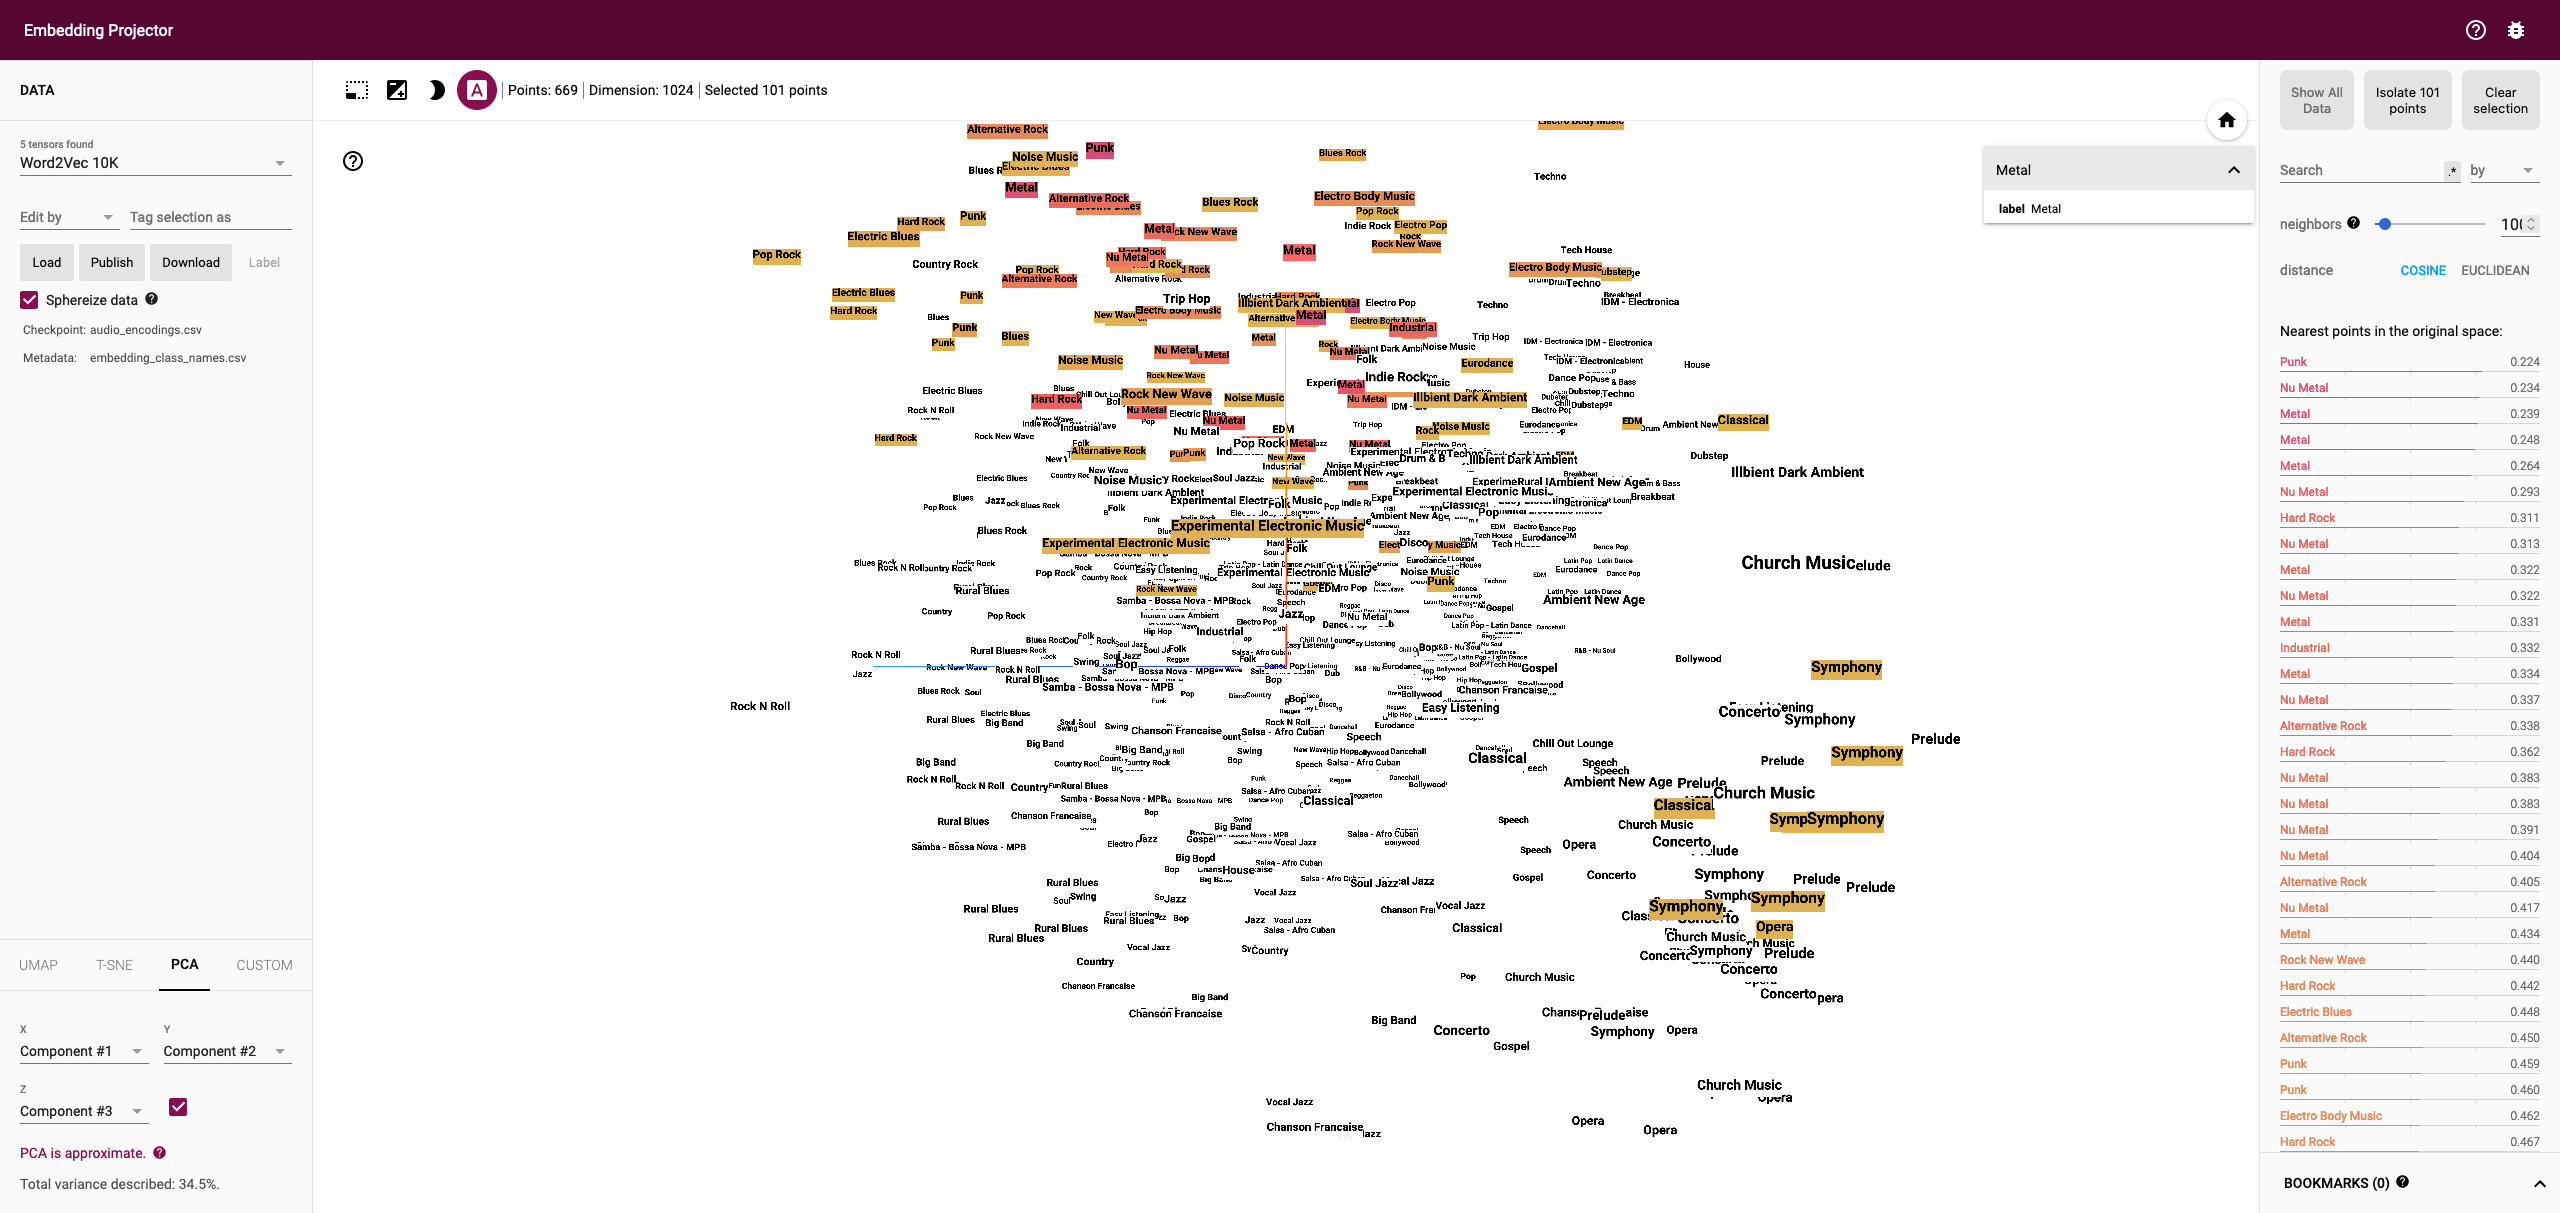

### Exploring dimensionality reduction techniques

Now we will cluster the audio encodings. Clustering algorithms tend not to perform well with high dimensional data. So at first we will apply dimensionality reduction techniques.

In [156]:
# Loading the encodings
df = pd.read_csv(data_dir+'audio_encodings.csv', sep='\t', header=None)
audio_classes = np.array(pd.read_csv(data_dir+'embedding_class_names.csv', sep='\t', header=None))

single_label_dataset_df=pd.read_csv(data_dir+'musimotion_testset_single_class_v2.csv')
audio_names = np.array(single_label_dataset_df['file_name'])

std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df)

In [158]:
#visualizing embeddings

def plot_visualization(data, labels, title, cluster=False, audio_classes=audio_classes):
    
    if cluster:
        data = np.hstack([data, labels, audio_classes])
        df = pd.DataFrame(data=data, columns=("Dimension 1", "Dimension 2", "Cluster", "Genre"))
        hover_data=["Cluster", 'Genre']
        color="Cluster"
    else:
        data = np.hstack([data, labels])
        df = pd.DataFrame(data=data, columns=("Dimension 1", "Dimension 2", "Genre"))
        hover_data=['Genre']
        color="Genre"
    
    fig = px.scatter(df, x="Dimension 1", y="Dimension 2", color=color, hover_data=hover_data, title=title)
    
    fig.show()

#### PCA

We will start with PCA first

To see the variance level of different components, let's do an exploratory analysis. We will start with 25.

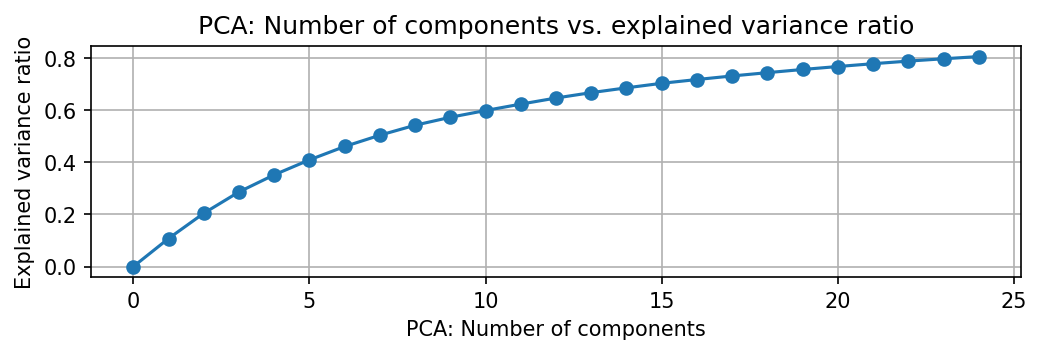

In [312]:
nums = np.arange(25)

var_ratio = []
for num in nums:
    pca = PCA(n_components=num)
    pca.fit_transform(scaled_df)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(8,2),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('PCA: Number of components')
plt.ylabel('Explained variance ratio')
plt.title('PCA: Number of components vs. explained variance ratio')
plt.show()

We can see that with 10 components it can capture up to 60% of the variance in the data.

For simplicity we will use 2 dimensions throughout the rest. It should be noted that we should increase dimensions if the clustering algorithms can generate better performance.

In [160]:
pca = PCA(n_components=2)
pca_encodings=pca.fit_transform(scaled_df)

In [161]:
plot_visualization(pca_encodings, classes, 'PCA Visualization')

As the graph is interactive, we can see it capturing the information somewhat well by hovering over it. We will compare it in the clustering cases later.

We can see that with 10 components it can capture up to 60% of the variance in the data.

#### tSNE

Fine tuning tSNE is a bit tricky and with this small dataset it may not be optimal. So we will use three simple cases to visualize it,

In [162]:
def tSNE_exploration(df, classes, perplexity, n_iter, number):
    
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter)
    tsne_encodings = tsne.fit_transform(df)
    plot_visualization(tsne_encodings, classes, 'tSNE Visualization '+ str(number))
    
    return tsne_encodings

In [165]:
tsne_encodings_1 = tSNE_exploration(scaled_df, classes, 3, 250, 1)

In [166]:
tsne_encodings_2 = tSNE_exploration(scaled_df, classes, 30, 500, 2)

In [167]:
tsne_encodings_3 = tSNE_exploration(scaled_df, classes, 15, 1000, 3)

We should also consider UMAP. For now it is not explored.

## Clustering audio encodings

Now we will explore some clustering algorithms. This link https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html provides a very nice overview about different algorithms. It is recommended to use HDBSCAN for high dimensional data. It is worth mentioning that finding balanced clusters requires explorations.

In [194]:
# here we will cluster, visualize, and report results

def cluster_data(algorithm, args, kwds, algorithm_name, data, reduction_technique, audio_classes=audio_classes, audio_names=audio_names):
    
    clusters = algorithm(*args, **kwds).fit_predict(data)
    
    cluster_info_dict = dict()
    
    for cluster_number in range(max(clusters)+1):
        
        info_dict=dict()
        
        indices = np.asarray(clusters==cluster_number).nonzero()
        
        audio_classes=audio_classes.reshape(audio_classes.shape[0])
        audio_names=audio_names.reshape(audio_names.shape[0])
        
        
        info_dict['Genres']=audio_classes[indices]
        info_dict['files']=audio_names[indices]
        
        cluster_info_dict[cluster_number]=info_dict
    
    labels = clusters.reshape(clusters.shape[0], 1)
    
    title = "Clustering Algorithm: "+algorithm_name+", Dimensionality Reduction: "+reduction_technique
    
    plot_visualization(data, labels, title, True)
    
    print("Total clusters: "+str(max(clusters)+1))
                       
    return max(clusters)+1, cluster_info_dict

In [191]:
clustering_data = [pca_encodings, tsne_encodings_1]
reduction_techniques = ['PCA', 'tSNE']

### K Means

Although K Means is partioning algorithm, not clustering technically, still to have a benchmark we can start with it.

In [209]:
for i in range(2):

    KMeans_total_cluster_number, KMeans_cluster_info= cluster_data(cluster.KMeans, (), {'n_clusters':15}, "K Means", clustering_data[i], reduction_techniques[i])

Total clusters: 15


Total clusters: 15


We can see that tSNE looks better. Let's explore one cluster there (3). We can see it's not very good.

In [267]:
KMeans_cluster_info[3]['Genres']

array(['Big Band', 'Big Band', 'Rural Blues', 'Rural Blues',
       'Rural Blues', 'Bop', 'Bop', 'Bop', 'Bop', 'Bop', 'Bop',
       'Chanson Francaise', 'Chanson Francaise', 'Chanson Francaise',
       'Country', 'Country', 'Gospel', 'House', 'Jazz', 'Jazz',
       'Big Band', 'Pop', 'Rural Blues', 'Rural Blues', 'Rural Blues',
       'Rural Blues', 'Rural Blues', 'Rural Blues',
       'Samba - Bossa Nova - MPB', 'Soul Jazz', 'Jazz', 'Swing', 'Swing',
       'Vocal Jazz', 'Vocal Jazz'], dtype=object)

### Affinity Propagation

In [211]:
for i in range(2):

    affinity_propagation_total_cluster_number, affinity_propagation_cluster_info= cluster_data(cluster.AffinityPropagation, (), {'preference':-110.0, 'damping':0.95}, "Affinity Propagation", clustering_data[i], reduction_techniques[i])

Total clusters: 38


Total clusters: 4


### Spectral Clustering

In [212]:

for i in range(2):

    spectral_clustering_total_cluster_number, spectral_clustering_cluster_info= cluster_data(cluster.SpectralClustering, (), {'n_clusters':15}, "Spectral Clustering", clustering_data[i], reduction_techniques[i])

Total clusters: 15


Total clusters: 15


Spectral Clustering looks promising. Let's see 9. It's close in genre

In [268]:
spectral_clustering_cluster_info[9]['Genres']

array(['Big Band', 'Chanson Francaise', 'Church Music', 'Church Music',
       'Church Music', 'Church Music', 'Church Music', 'Church Music',
       'Church Music', 'Church Music', 'Church Music', 'Classical',
       'Illbient Dark Ambient', 'Opera', 'Opera', 'Opera', 'Opera',
       'Opera', 'Opera', 'Opera', 'Opera', 'Opera', 'Pop', 'Symphony',
       'Vocal Jazz'], dtype=object)

### Agglomerative Clustering

In [216]:
for i in range(2):

    agglomerative_clustering_total_cluster_number, agglomerative_clustering_cluster_info= cluster_data(cluster.AgglomerativeClustering, (), {'n_clusters':15, 'linkage':'ward'}, "Agglomerative Clustering", clustering_data[i], reduction_techniques[i])

Total clusters: 15


Total clusters: 15


### DBSCAN

In [217]:
for i in range(2):

    DBSCAN_total_cluster_number, DBSCAN_cluster_info= cluster_data(cluster.DBSCAN, (), {'eps':0.025}, "DBSCAN", clustering_data[i], reduction_techniques[i])

Total clusters: 1


Total clusters: 10


### HDBSCAN

In [218]:
for i in range(2):

    HDBSCAN_total_cluster_number, HDBSCAN_cluster_info= cluster_data(hdbscan.HDBSCAN, (), {'min_cluster_size':15}, "HDBSCAN", clustering_data[i], reduction_techniques[i])

Total clusters: 2


Total clusters: 3


To conclude, it can be observed that in original data, the semantic relatedness was fairly close, and these clustering algorithms did not do better. We need to fine tune it, also we may need additional data to get a better performance.

## Utilizing music data as a training dataset for the CLAP model

The idea is to fine tune the audio encoder and then use it for a supervised classification using our music dataset.

In [221]:
class Musimotion_Dataset(Dataset):
    
    def __init__(self, df, root, label_col, file_col, classes):

        self.root=root
        self.df =df
        self.label_col = label_col
        self.file_col = file_col
        
        self.targets, self.audio_paths = [], []
        
        self.df[self.label_col] = self.df[self.label_col].str.replace('_',' ')
        
        
        for _, row in tqdm(self.df.iterrows()):
            
            self.targets.append(row[self.label_col])
            
            file_path = self.root+row[self.file_col]
            
            self.audio_paths.append(file_path)
            
        self.class_to_idx = {}
        self.classes = classes
        
        
        for i, category in enumerate(self.classes):
            self.class_to_idx[category] = i
            
    
    def __getitem__(self, index):
        
        audio_path, class_name = self.audio_paths[index], self.targets[index]
        target = torch.tensor(self.class_to_idx[class_name])
        
        return audio_path, target

    def __len__(self):
        return len(self.targets)

In [287]:
def train_model(model, clap_wrapper, dataloaders, criterion, optimizer, num_epochs=5):
    
    since = time.time()
    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for audio_paths, labels in dataloaders[phase]:
                
                
                inputs=clap_wrapper.preprocess_audio(audio_paths, resample=False)
                
                inputs = inputs.reshape(inputs.shape[0], inputs.shape[2])
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                
                    logits = model.audio_encoder(inputs)[0]
                    
                    probas = torch.softmax(logits, dim=1)
                    
                    loss = criterion(logits, labels)
                    loss = Variable(loss, requires_grad = True)

                    #_, preds = torch.max(outputs, 1)
                    _, preds = torch.max(probas, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [261]:
def evaluation(model, clap_wrapper, dataloader):
    model = model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    correct_pred, num_examples = 0, 0
    y_true_labels = []
    y_predicted_probability_scores = []
    y_predicted_labels = []
    for audio_paths, labels in dataloader:
                
        inputs=clap_wrapper.preprocess_audio(audio_paths, resample=False)
                
        inputs = inputs.reshape(inputs.shape[0], inputs.shape[2])
                
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            
            logits = model.audio_encoder(inputs)[0]
        
        probas = torch.softmax(logits, dim=1)
        proba_score, predicted_labels = torch.max(probas, 1)
        
        num_examples += labels.size(0)
        correct_pred += (predicted_labels == labels).sum()
        
        y_true_labels.extend(labels.tolist())
        y_predicted_probability_scores.extend(proba_score.tolist())        
        y_predicted_labels.extend(predicted_labels.tolist())
        
        acc = correct_pred.double() / num_examples
        
        return acc
        

In [259]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


Now we will create the dataloders

In [288]:
annotation_file_name='musimotion_testset_single_class_v2.csv'
batch_size=10
label_col = 'class_name'
file_col = 'file_name'

df_all_data = pd.read_csv(data_dir+annotation_file_name)

classes = [x.replace('_',' ') for x in sorted(df_all_data[label_col].unique())]


# Here we are splitting the dataset into train, test, and valid sets
# We should stratify the classes across tree sets
df_train_valid, df_test = train_test_split(df_all_data, test_size=0.10, stratify=df_all_data[label_col])

df_train, df_valid = train_test_split(df_train_valid, test_size=0.11, stratify=df_train_valid[label_col])

train_data = Musimotion_Dataset(df_train, audio_file_dir, label_col, file_col, classes)
val_data = Musimotion_Dataset(df_valid, audio_file_dir, label_col, file_col, classes)
test_data = Musimotion_Dataset(df_test, audio_file_dir, label_col, file_col, classes)

# We will use these dataloaders to feed the transformed dataset in the model for training
train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, drop_last=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, drop_last=False)

dataloaders_dict = dict()

dataloaders_dict['train']=train_dataloader
dataloaders_dict['val']=val_dataloader

535it [00:00, 7487.83it/s]
67it [00:00, 6392.01it/s]
67it [00:00, 2767.78it/s]


### Fine-tuning CLAP model for supervised classification

Now we will use the CLAP model. The idea is to fine tune the audio encoder and then use it for a supervised classification using our music dataset. To do this, we need to modify the model architecture a bit. The last layer in the model is a linear 1024 embeddings. We will add another layer their for classifications.

In [289]:
# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

clap = CLAPWrapper(weights_pth, '2023', use_cuda=False)
model = clap.clap
set_parameter_requires_grad(model, feature_extract)
#adding another layer
model.audio_encoder.projection.classification = nn.Linear(1024, len(classes), bias=False)

In [235]:
# To check if the model architecture is sucessfully modified,

print(model.audio_encoder.projection)

Projection(
  (linear1): Linear(in_features=768, out_features=1024, bias=False)
  (linear2): Linear(in_features=1024, out_features=1024, bias=False)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.5, inplace=False)
  (classification): Linear(in_features=1024, out_features=67, bias=False)
)


In [236]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [272]:
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.Adam(params_to_update)

Params to learn:
	 logit_scale
	 audio_encoder.base.htsat.bn0.weight
	 audio_encoder.base.htsat.bn0.bias
	 audio_encoder.base.htsat.patch_embed.proj.weight
	 audio_encoder.base.htsat.patch_embed.proj.bias
	 audio_encoder.base.htsat.patch_embed.norm.weight
	 audio_encoder.base.htsat.patch_embed.norm.bias
	 audio_encoder.base.htsat.layers.0.blocks.0.norm1.weight
	 audio_encoder.base.htsat.layers.0.blocks.0.norm1.bias
	 audio_encoder.base.htsat.layers.0.blocks.0.attn.relative_position_bias_table
	 audio_encoder.base.htsat.layers.0.blocks.0.attn.qkv.weight
	 audio_encoder.base.htsat.layers.0.blocks.0.attn.qkv.bias
	 audio_encoder.base.htsat.layers.0.blocks.0.attn.proj.weight
	 audio_encoder.base.htsat.layers.0.blocks.0.attn.proj.bias
	 audio_encoder.base.htsat.layers.0.blocks.0.norm2.weight
	 audio_encoder.base.htsat.layers.0.blocks.0.norm2.bias
	 audio_encoder.base.htsat.layers.0.blocks.0.mlp.fc1.weight
	 audio_encoder.base.htsat.layers.0.blocks.0.mlp.fc1.bias
	 audio_encoder.base.htsat.l

In [270]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
model, hist = train_model(model, clap, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

In [ ]:
test_acc = evaluation(model, clap, test_dataloader)

print('Fine-tuned model test dataset accuracy: {:4f}'.format(test_acc))

In [290]:
#saving the finetuned model
torch.save(model.state_dict(), data_dir+'clap_fine_tuned.pth')

### Zero-shot classification with CLAP model architecture

Now for comparison we will try to use the zero-shot classification with the music test dataset.

In [291]:
dataset = test_data

prompt = 'the genre of this song is '
y = [prompt + x for x in dataset.classes]

# Load and initialize CLAP

clap_model = CLAPWrapper(weights_path, version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

# Computing audio embeddings
y_preds, y_labels = [], []
for i in tqdm(range(len(dataset))):
    x, target = dataset.__getitem__(i)
    audio_embeddings = clap_model.get_audio_embeddings([x], resample=True)
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)
    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    y_preds.append(y_pred)
    y_labels.append(target)
    
y_preds = np.concatenate(y_preds, axis=0)
acc = accuracy_score(y_labels, np.argmax(y_preds, axis=1))
print('Zero shot inference test dataset accuracy: {:4f}'.format(acc))

100%|███████████████████████████████████████████| 67/67 [02:02<00:00,  1.83s/it]

Zero shot inference test dataset accuracy: 0.208955


## Similar open source models

### (1) Data2vec 2.0: self-supervised learning for vision, speech and text

Github link: https://github.com/facebookresearch/fairseq/tree/main/examples/data2vec

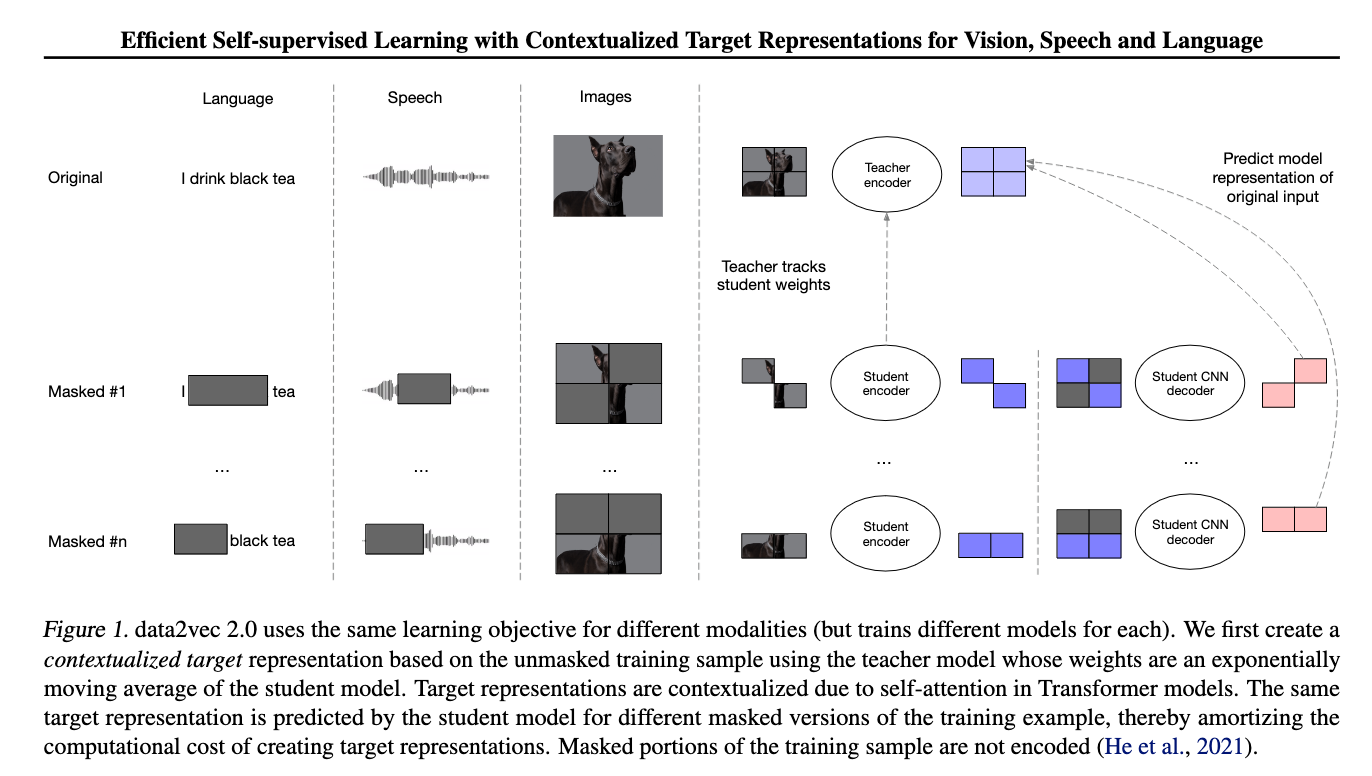

### (2) CoDi: Any-to-Any Generation via Composable Diffusion

Github link: https://github.com/microsoft/i-Code/tree/main/i-Code-V3

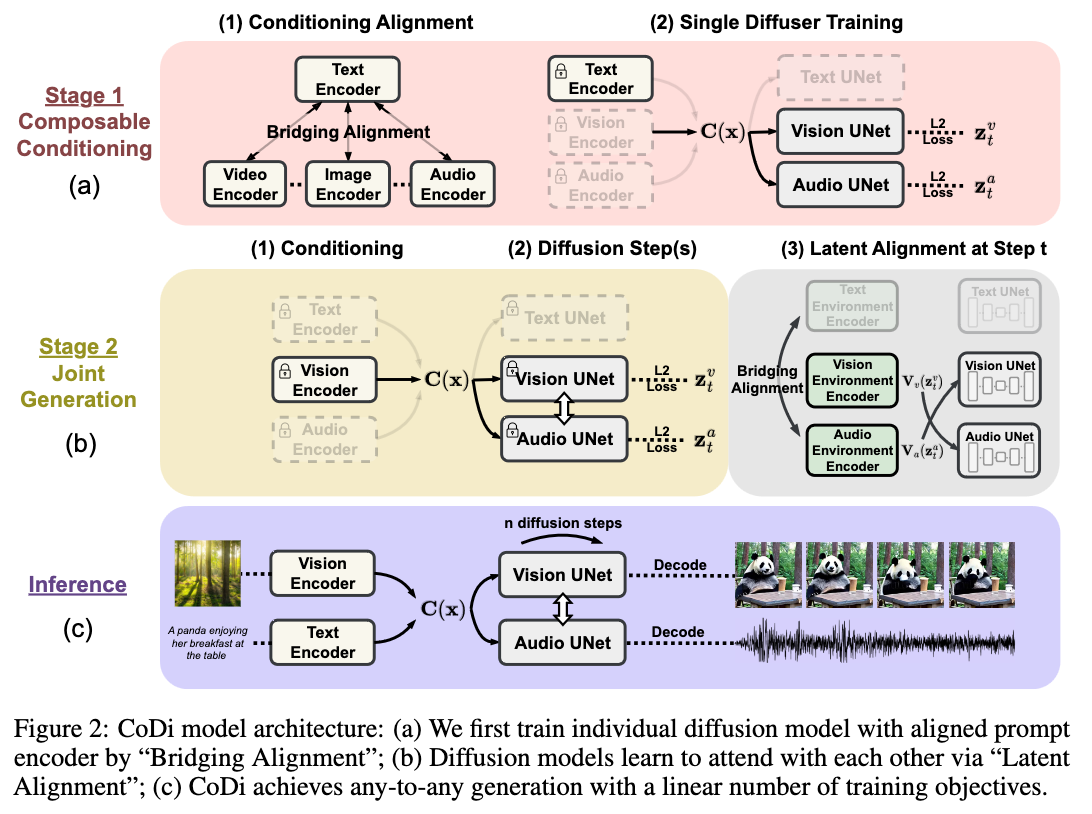